In [1]:
import re, os
import numpy as np
from pathlib import Path
from collections import defaultdict

class Data:
    def __init__(self, model: int, val_cap_time_step: str = None):
        self.model = model
        if model == 0:
            self.path_base = Path.cwd() / "resistor" / "data"
        elif model == 1:
            self.val_cap_time_step = val_cap_time_step
            self.path_base = Path.cwd() / "resistor_capacitor" / "data"

        self.config_to_seeds, self.config_to_num_seed = self.get_configs()
    
    def get_configs(self):
        is_float = re.compile(r'^[+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?$').match
        tmp = defaultdict(list)
        if self.model: val_cap_time_step = self.val_cap_time_step

        with os.scandir(self.path_base) as it_length:
            for e_length in it_length:
                if not (e_length.is_dir() and e_length.name.isdigit()):
                    continue
                length = int(e_length.name)

                with os.scandir(e_length.path) as it_width:
                    for e_width in it_width:
                        name_w = e_width.name
                        if not (e_width.is_dir() and is_float(name_w)):
                            continue
                        width = float(name_w)

                        if self.model:
                            path_params = os.path.join(e_width.path, val_cap_time_step)
                            if not os.path.isdir(path_params):
                                continue                          

                            seeds = []
                            with os.scandir(path_params) as it_seed:
                                for e_seed in it_seed:
                                    if not (e_seed.is_dir() and e_seed.name.isdigit()):
                                        continue
                                    seed = int(e_seed.name)

                                    with os.scandir(e_seed.path) as it_files:
                                        if next(it_files, None) is not None:
                                            seeds.append(seed)
                                            
                        else:
                            seeds = []
                            with os.scandir(e_width.path) as it_seed:
                                for e_seed in it_seed:
                                    if not (e_seed.is_dir() and e_seed.name.isdigit()):
                                        continue
                                    seed = int(e_seed.name)

                                    with os.scandir(e_seed.path) as it_files:
                                        if next(it_files, None) is not None:
                                            seeds.append(seed)


                        if seeds:
                            tmp[(length, width)] = np.array(sorted(seeds), dtype=np.int32)

        keys = sorted(tmp.keys(), key=lambda k: (k[0], k[1]))
        config_to_seeds = {k: tmp[k] for k in keys}
        config_to_num_seed = {k: tmp[k].size for k in keys}
        return config_to_seeds, config_to_num_seed

In [2]:
# data_r = Data(model=0, val_cap_time_step=None)

In [3]:
data_rc = Data(model=1, val_cap_time_step="1.0_0.01")

In [32]:
sum(list(data_rc.config_to_num_seed.values()))

160000

In [4]:
import matplotlib.pyplot as plt

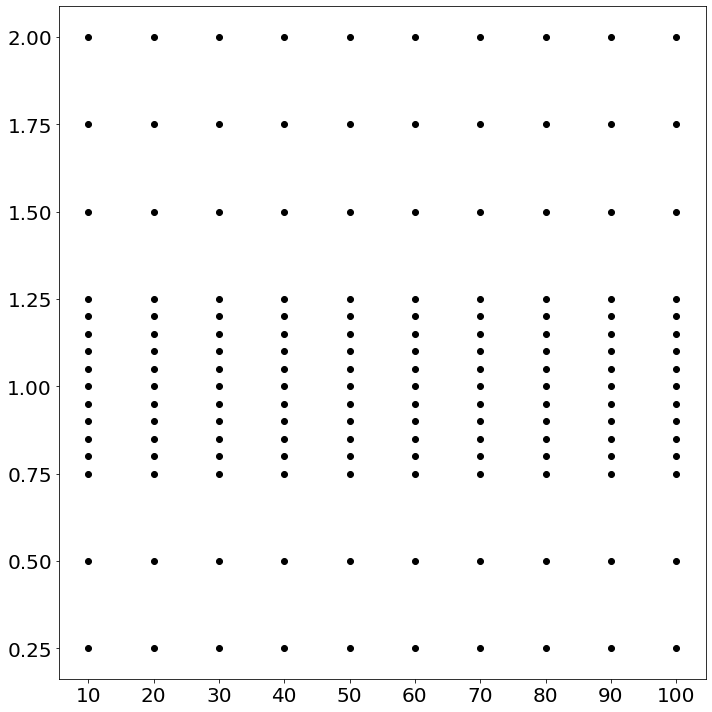

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

for (length, width) in list(data_rc.config_to_num_seed):
    plt.scatter(length, width, c="black")


ax.set_xticks(range(10, 110, 10))
ax.tick_params(axis='both', labelsize=20)
# ax.tick_params(axis='y', which='both', labelright=True)

plt.tight_layout()
plt.show()

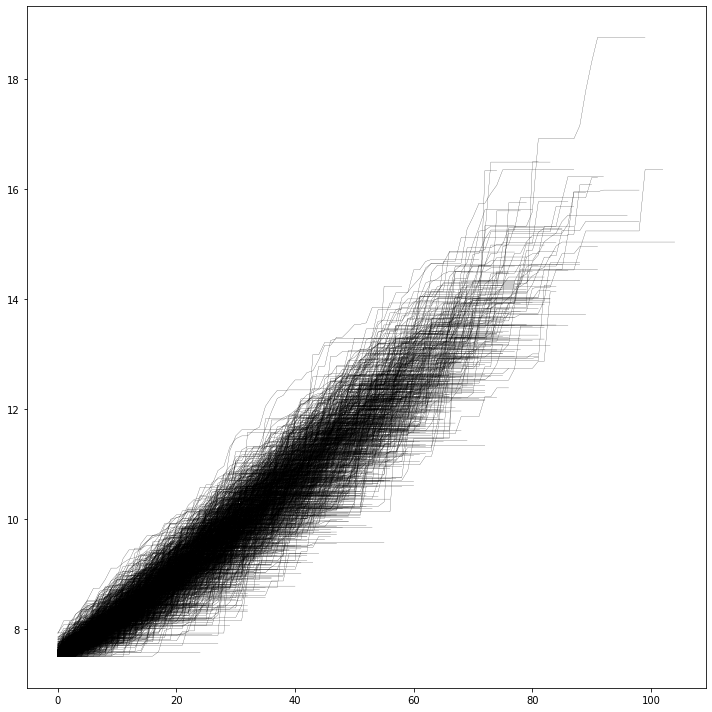

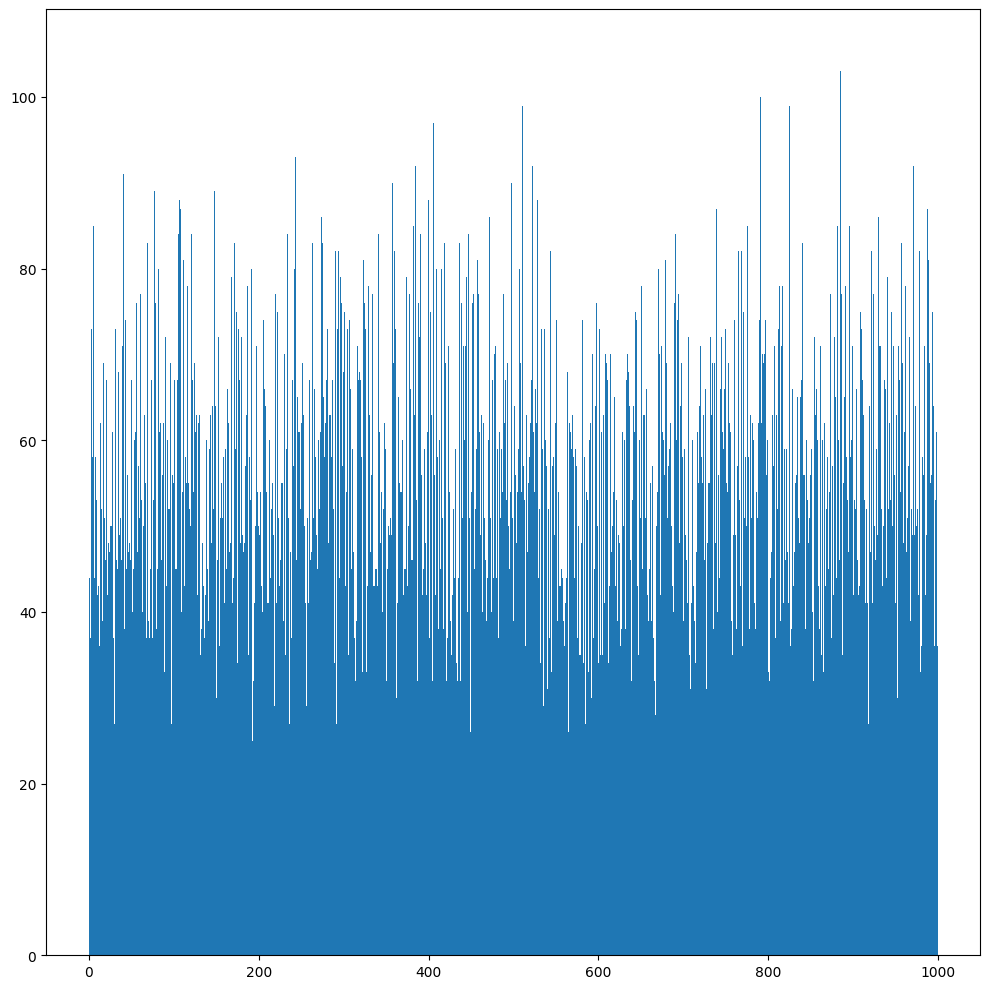

In [29]:
length, width = 20, 1.25
path = data_rc.path_base / str(length) / str(width) / data_rc.val_cap_time_step 

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

nums_broken_edge = []
for seed in data_rc.config_to_seeds[(length, width)]:
    volts_ext = np.load(path / str(seed) / "volts_ext.npy")
    nums_broken_edge.append(len(volts_ext))
    ax.plot(volts_ext, lw=0.2, c="black")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.bar(data_rc.config_to_seeds[(length, width)], nums_broken_edge, width=1, ec="none")
plt.tight_layout()
plt.show()